In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi']=200
import glob
from matplotlib.ticker import StrMethodFormatter
mpl.rcParams['figure.facecolor']='w'
mpl.rcParams.update({'font.size':11,'font.family':'STIXGeneral'})

import matplotlib.ticker as mtick
import matplotlib.patches as mpatches

import os
import warnings

In [2]:
mpl.rcParams['figure.facecolor']= (0.0, 0.0, 0.0, 0.0)

In [3]:
'''
The function `plot` takes in 3 parameters:
1. A list of files (files) to be plotted and averaged over
2. A list of age-bands (eg. ['L'] or ['L','M1','M2','H'], etc.). [Default is all age-bands]
3. A list of disease states (eg. ['MI','SI','H'], or even just ['I'] (represents all infected)) [Default it all infected]

It also has many other optional plotting parameters
'''

"\nThe function `plot` takes in 3 parameters:\n1. A list of files (files) to be plotted and averaged over\n2. A list of age-bands (eg. ['L'] or ['L','M1','M2','H'], etc.). [Default is all age-bands]\n3. A list of disease states (eg. ['MI','SI','H'], or even just ['I'] (represents all infected)) [Default it all infected]\n\nIt also has many other optional plotting parameters\n"

In [4]:
def split_by(files,choice,val,shift=1):
#     print(shift)
    if(len(files)==0):
       raise ValueError("File list empty for "+str(choice)+" = "+str(val)+".")
        
    
    samplefilename = np.array(files[0].replace("/","_").split("_"))
        
    if(len(np.where(samplefilename==choice)[0])==0):
        print("Invalid Choice!")
        return(2)
    index = np.where(samplefilename==choice)[0][0]+shift
    
    result = []
    
    for file in files:
        if file.replace("/","_").split("_")[index]==str(val):
            result.append(file)
    
    if(len(result)==0):
        warnings.warn("Returning empty file list for "+str(choice)+" = "+str(val)+".")
    return result

In [5]:
def cleanFiles(files, file_length, delimiter): # To remove "incomplete" files (i.e. with length<length)
    if(len(files)==0):
        raise ValueError("File list empty.")
        
    random_file = np.random.choice(files)
    avg = np.zeros_like(np.genfromtxt(random_file, delimiter=delimiter))  # Choose random file and create an array of zeros like it
    
    tmpcounter=0
    
    while(len(avg)<file_length and tmpcounter<len(files)):
        random_file = np.random.choice(files) # Make sure you choose a file that has the minimum file length
        avg = np.zeros_like(np.genfromtxt(random_file, delimiter=","))  # Choose random file and create an array of zeros like it
        tmpcounter+=1
    
    if(tmpcounter==len(files)):
        raise ValueError("Error! Unable to find an appropriately sized file. Are you sure about the `file_length` you have set?")
        
    return files,avg
        
def rc():                    # Output a random colour
    r = np.random.uniform()
    b = np.random.uniform()
    g = np.random.uniform()
    return (r, g, b)

In [6]:
Low, Mid1, Mid2, High = 0,1,2,3
S,E,A,P,MI,SI,R,H,D,V = range(0,10)

age_bands = [Low, Mid1, Mid2, High]
states    = [S,E,A,P,MI,SI,R,H,D,V]

allinfected = [A,P,MI,SI,H]

# To check if column number is correct

def colnum_string(n):
    string = ""
    while n > 0:
        n, remainder = divmod(n - 1, 26)
        string = chr(65 + remainder) + string
    return string

# print(colnum_string(1))

In [8]:
def plot(files, plot_ages = [Low, Mid1, Mid2, High], plot_states = [A,P,MI,SI,H], color='firebrick', alpha=0.1, ls='solid', lw=1, label="Total Infected", disease_states = [S,E,A,P,MI,SI,R,H,D,V], n_pop=20316,file_length = 400, plot_relative_fraction=False,print_log=False, plot_fill=False, delimiter=",", return_array=False, fig=None,ax=None):
    
    if(fig==None or ax == None):
        fig,ax = plt.subplots()
    
    files,avg = cleanFiles(files, file_length,delimiter)                          # Check files for length issues etc. Return an empty array for averages
    
    t=0
    age_names = np.array(["Low", "Mid1", "Mid2", "High"])
    state_names = np.array(["S","E","A","P","MI","SI","R","H","D","V"])
    n_states = len(disease_states)
        
        
    def plotOne(array,alpha,label=None):

        toPlotSum = np.zeros_like(array[:,0])
            
        relative_pop = 0
        for age in plot_ages:
            firstRow = array[0][1:]
            relative_pop += np.sum(firstRow[age*n_states: (age+1)*n_states-2]) # Add up only those columns for the age range `age`. -2 since n_states includes V and BS, which is not a state
            
            if(print_log): print("Age range", age_names[age], "has", np.sum(firstRow[age*n_states: (age+1)*n_states-2]), "people") # TEST
            
            for state in plot_states: 
                columnNumber = 1 + n_states*age + state # time column + (columns before age `age`) + column number in specific age band `age`
#                 if(print_log): print(age_names[age],state_names[state], colnum_string(columnNumber+1), columnNumber) # To check that the right column is being used (it is!)
                
                toPlotSum += array[:,columnNumber]
        
        if(print_log): print("All ages have",age_pop,"people")   # TEST
        
        denominator = relative_pop if plot_relative_fraction else n_pop # Divide by relative population, if `plot_relative_fraction==True`
                
        ax.plot(array[:,t], toPlotSum/denominator * 100, alpha=alpha, lw=lw, ls=ls, c=color, label=label)
        
        return toPlotSum/denominator

    
    counter = 0
    toPlotStd = np.zeros((file_length, len(files)))
    
    for file in files:
        
        data = np.genfromtxt(file,delimiter=delimiter)
        if(np.shape(data)!=np.shape(avg)):
            if(print_log):
                print("File",file,"has a different shape, skipping it.")
            continue
        
        try:
            avg += data
            if(plot_fill==False):
                toPlotStd[:,counter] = plotOne(data,alpha) # Keep track of each run to calculate standard deviations. 
            else:
                toPlotStd[:,counter] = plotOne(data,0)     # Only plot individual runs (alpha>0) if `plot_fill=False`.
            
            counter+=1
        
        except ValueError:
            if(print_log):
                print('File',file,'incomplete, skipping it.')
#             os.remove(file) # remove file from directory
            continue          # skip to next file
        
        
    # CHECK IF COLUMNS NEED TO BE REMOVED #############################################################
    temp = len(files) 
    remove_columns = counter<temp
    if(print_log and remove_columns):
            print("Some files ignored, deleting columns from standard deviation array: ", end="")
    
    while(counter<temp):
        toPlotStd = np.delete(toPlotStd, obj=-1, axis=1)
        temp -= 1
        if(print_log):
            print(np.shape(toPlotStd),end="->")
        
    if(print_log and remove_columns):
        print("Done")
    # DONE #########################################################################################
    

    avg = avg/counter                      
    plottable = plotOne(avg,1,label=label) # Get average run
    std = np.std(toPlotStd,axis=1)         # Get standard deviation of non-zero runs
    
    if(plot_fill == True):
        ax.fill_between(avg[:,t], (plottable+1.96*std)*100, (plottable-1.96*std)*100,  color=color,alpha=2*alpha)
    
    
    # PLOT DETAILS ####################################
    if(plot_relative_fraction):
        ax.set_ylabel("Relative Fraction of Population")
    else:
        ax.set_ylabel("Fraction of Total Population")  
    ax.set_xlabel("Time (Days)")
    
    ax.yaxis.set_major_formatter(mtick.PercentFormatter(decimals=1))  # Format y-axis as percentage
    # DONE ############################################
    
    if(return_array):
        return avg,plottable

In [9]:
BaseName = "./data/"
Scenario = ""

def getFiles(ScenarioName, seropositivity, vaccRate):
    files = glob.glob(BaseName+ScenarioName+"/Age*.txt")
    
    return split_by(split_by(files, "IR", seropositivity), "VR", vaccRate)

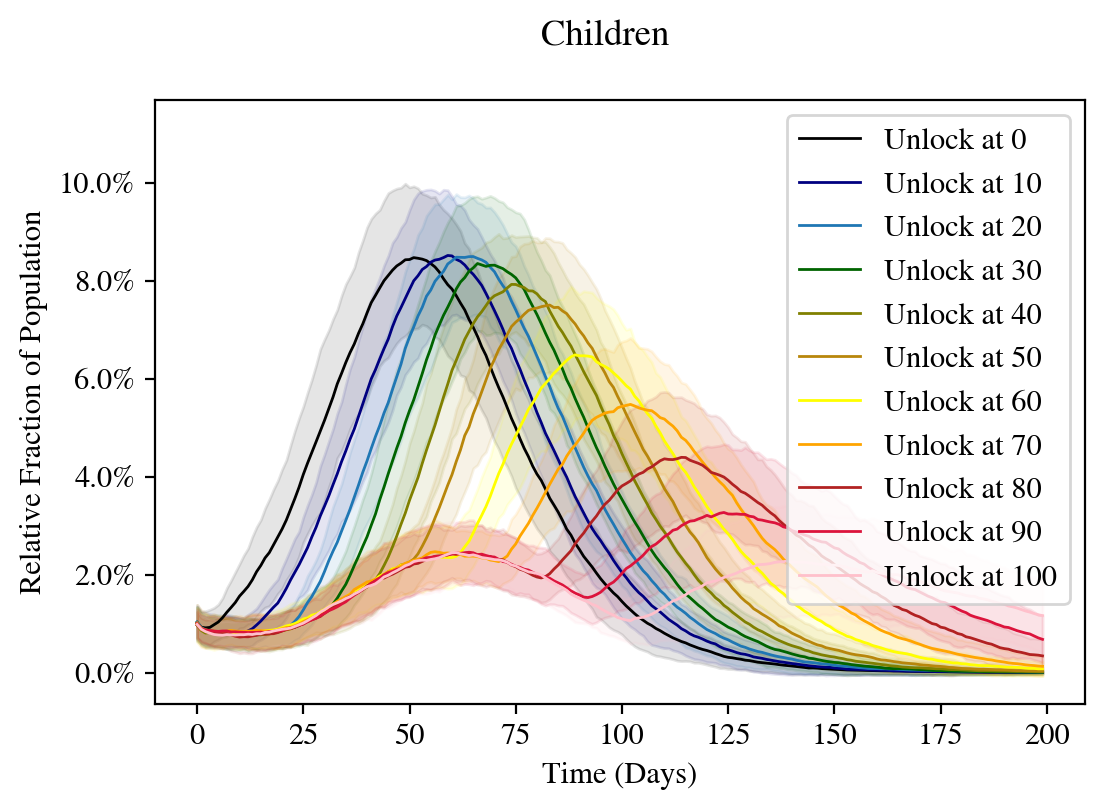

In [22]:
unlocks = [0,10,20,30,40,50,60,70,80,90,100]

colors = ['black', 'navy', 'tab:blue', 'darkgreen', 'olive', 'darkgoldenrod', 'yellow', 'orange', 'firebrick', 'crimson', 'pink']

fig,ax = plt.subplots()

for u in range(len(unlocks)):
    u_files = split_by(getFiles("",30,0.2),"UnlockSchoolsAt",unlocks[u])
    
    plot(u_files, plot_ages = [0,1], plot_states = [A,P,MI,SI,H],plot_relative_fraction=True ,color=colors[u], file_length=200, delimiter=None,fig=fig,ax=ax, label="Unlock at "+str(unlocks[u]), plot_fill=True,alpha=0.05)

fig.suptitle("Children")
plt.legend()

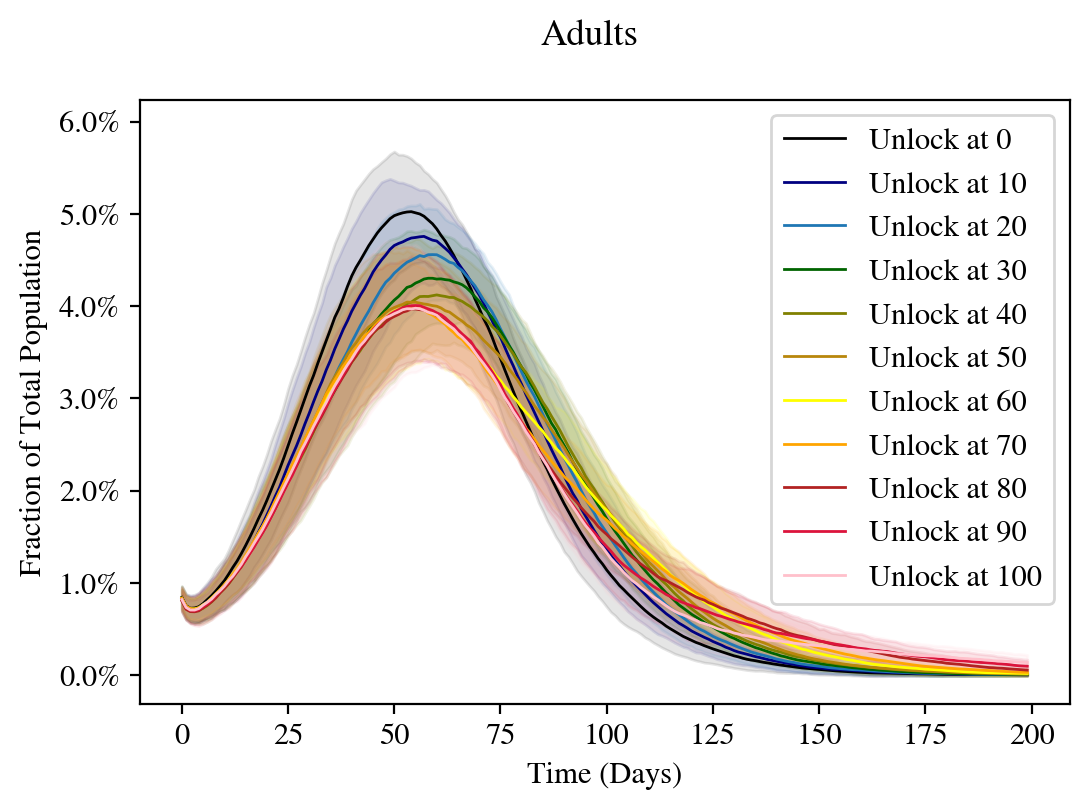

In [23]:
unlocks = [0,10,20,30,40,50,60,70,80,90,100]

colors = ['black', 'navy', 'tab:blue', 'darkgreen', 'olive', 'darkgoldenrod', 'yellow', 'orange', 'firebrick', 'crimson', 'pink']

fig,ax = plt.subplots()

for u in range(len(unlocks)):
    u_files = split_by(getFiles("",30,0.2),"UnlockSchoolsAt",unlocks[u])
    
    plot(u_files, plot_ages = [2,3,4,5,6,7,8], plot_states = [A,P,MI,SI,H], color=colors[u], file_length=200, delimiter=None,fig=fig,ax=ax, label="Unlock at "+str(unlocks[u]), plot_fill=True,alpha=0.05)

fig.suptitle("Adults")
plt.legend()

In [ ]:
betaConstantSchoolsOpen = []

def createArray(Scenario):
    vaccRates=[0.0,0.2,0.4]
    files = []

    for v in range(len(vaccRates)):
        vaccRate = vaccRates[v]

        files.append([])
        files[v].append(getFiles(Scenario, 30, vaccRate))
        files[v].append(getFiles(Scenario, 40, vaccRate))
        files[v].append(getFiles(Scenario, 50, vaccRate))
    
    return files

IRs = ["30%", "40%", "50%"]
VRs= ["No Vaccination", "0.2% DVR", "0.4% DVR"]

labels = []
for VR in VRs:
    dummy = []
    for IR in IRs:
        dummy.append("IR "+IR + ", " + VR)
    labels.append(dummy)
    

In [ ]:
betaConstantSchoolsOpen = createArray("BetaConstantSchoolsOpen")
betaConstantSchoolsClosed = createArray("BetaConstantSchoolsClosed")
betaRampedSchoolsOpen = createArray("BetaRampedSchoolsOpen")
betaRampedSchoolsClosed = createArray("BetaRampedSchoolsClosed")

In [ ]:
fig, axes = plt.subplots(2,3,figsize=(16,8))
ylims = [(0, 100),(0,15)]
row = [[R], [A,P,MI,SI,H]]

fig.suptitle(r"Comparing Schools Open and Closed ($\beta =$ 0.7)")

for s in range(len(IRs)):
    for r in range(len(row)):
        
        plot(betaConstantSchoolsOpen[0][s], color='navy', plot_states=row[r], label="Schools Open "+labels[0][s], fig=fig, ax=axes[r][s])
        plot(betaConstantSchoolsOpen[1][s], color='tab:blue', plot_states=row[r], label="Schools Open "+labels[1][s], fig=fig, ax=axes[r][s])
        
        plot(betaConstantSchoolsClosed[0][s], color='tomato', plot_states=row[r], label="Schools Closed "+labels[0][s], fig=fig, ax=axes[r][s])
        plot(betaConstantSchoolsClosed[1][s], color='firebrick', plot_states=row[r], label="Schools Closed "+labels[1][s], fig=fig, ax=axes[r][s])
        
        axes[r][s].set_ylim(ylims[r])
        axes[r][s].legend()
        axes[r][s].set_title("Initial Recovered: " + IRs[s])
plt.tight_layout()


In [ ]:
fig, axes = plt.subplots(2,3,figsize=(16,8))
ylims = [(0, 100),(0,15)]
row = [[R], [A,P,MI,SI,H]]

fig.suptitle(r"Comparing Different Vaccination Rates ($\beta =$ 0.7)")

for s in range(len(IRs)):
    for r in range(len(row)):
        
        
        plot(betaConstantSchoolsOpen[1][s], color='tab:blue', plot_states=row[r], label="Schools Open "+labels[1][s], fig=fig, ax=axes[r][s])
        plot(betaConstantSchoolsOpen[2][s], color='purple', plot_states=row[r], label="Schools Open "+labels[2][s], fig=fig, ax=axes[r][s])
        
        plot(betaConstantSchoolsClosed[1][s], color='firebrick', plot_states=row[r], label="Schools Closed "+labels[1][s], fig=fig, ax=axes[r][s])
        plot(betaConstantSchoolsClosed[2][s], color='darkgoldenrod', plot_states=row[r], label="Schools Closed "+labels[2][s], fig=fig, ax=axes[r][s])
        
        axes[r][s].set_ylim(ylims[r])
        axes[r][s].legend()
        axes[r][s].set_title("Initial Recovered: " + IRs[s])
plt.tight_layout()


In [ ]:
fig, axes = plt.subplots(2,3,figsize=(16,8))
ylims = [(0, 100),(0,15)]
row = [[R], [A,P,MI,SI,H]]

fig.suptitle(r"Comparing Schools Open and Closed (Effect of ramping up $\beta$)")

for s in range(len(IRs)):
    for r in range(len(row)):
        
        plot(betaConstantSchoolsOpen[0][s], color='navy', plot_states=row[r], label=r"Schools Open $\beta$ constant", fig=fig, ax=axes[r][s])
        plot(betaRampedSchoolsOpen[0][s], color='tab:blue', plot_states=row[r], label=r"Schools Open $\beta$ ramped", fig=fig, ax=axes[r][s])
        
        plot(betaConstantSchoolsClosed[0][s], color='tomato', plot_states=row[r], label=r"Schools Closed $\beta$ constant", fig=fig, ax=axes[r][s])
        plot(betaRampedSchoolsClosed[0][s], color='firebrick', plot_states=row[r], label=r"Schools Closed $\beta$ ramped", fig=fig, ax=axes[r][s])
        
        axes[r][s].set_ylim(ylims[r])
        axes[r][s].legend()
        axes[r][s].set_title("Initial Recovered: " + IRs[s])
plt.tight_layout()


In [ ]:
fig, axes = plt.subplots(2,3,figsize=(16,8))
ylims = [(0, 100),(0,15)]
row = [[R], [A,P,MI,SI,H]]

fig.suptitle(r"Comparing Different Vaccination Rates ($\beta$ ramps up to 0.7 over 90 days)")

for s in range(len(IRs)):
    for r in range(len(row)):
        
        
        plot(betaRampedSchoolsOpen[1][s], color='tab:blue', plot_states=row[r], label="Schools Open "+labels[1][s], fig=fig, ax=axes[r][s])
        plot(betaRampedSchoolsOpen[2][s], color='purple', plot_states=row[r], label="Schools Open "+labels[2][s], fig=fig, ax=axes[r][s])
        
        plot(betaRampedSchoolsClosed[1][s], color='firebrick', plot_states=row[r], label="Schools Closed "+labels[1][s], fig=fig, ax=axes[r][s])
        plot(betaRampedSchoolsClosed[2][s], color='darkgoldenrod', plot_states=row[r], label="Schools Closed "+labels[2][s], fig=fig, ax=axes[r][s])
        
        axes[r][s].set_ylim(ylims[r])
        axes[r][s].legend()
        axes[r][s].set_title("Initial Recovered: " + IRs[s])
plt.tight_layout()


In [ ]:
unlockSchoolsAt = []

days = [10,20,30,40,50,60,70,80]

fig,ax=plt.subplots()

fig.suptitle("Low Risk (0-18 year olds)")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",30),"VR",0.0),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    plot(dummy, color=rc(), plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax)
#     plt.ylim(0,100)
    print(len(dummy), dummy[0])
plt.legend()

In [ ]:
unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

plot(betaConstantSchoolsOpen[0][0], color='black', plot_ages=[Low],plot_states=[R],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True)

fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 30%")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",30),"VR",0.0),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[R],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True)
#     plt.ylim(0,100)
    print(len(dummy), dummy[0])

plot(betaConstantSchoolsClosed[0][0], color='black', plot_ages=[Low],plot_states=[R],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True)

plt.legend()
plt.ylim(0,100)
plt.show()


unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

plot(betaConstantSchoolsOpen[0][0], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 30%")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",30),"VR",0.0),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[A,P,MI,SI],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)
#     plt.ylim(0,100)
    print(len(dummy), dummy[0])

plot(betaConstantSchoolsClosed[0][0], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

plt.legend()
plt.ylim(0,20)
plt.show()


unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

plot(betaConstantSchoolsOpen[0][2], color='black', plot_ages=[Low],plot_states=[R],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True)

fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 50%")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",50),"VR",0.0),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[R],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True)
#     plt.ylim(0,100)
    print(len(dummy), dummy[0])

plot(betaConstantSchoolsClosed[0][2], color='black', plot_ages=[Low],plot_states=[R],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True)

plt.legend()
plt.ylim(0,100)
plt.show()


unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

plot(betaConstantSchoolsOpen[0][2], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True)

fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 50%")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",50),"VR",0.0),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[A,P,MI,SI],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True)
#     plt.ylim(0,100)
    print(len(dummy), dummy[0])

plot(betaConstantSchoolsClosed[0][2], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True)

plt.legend()
plt.ylim(0,20)
plt.show()

In [ ]:
unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

plot(betaConstantSchoolsOpen[1][0], color='black', plot_ages=[Low],plot_states=[R],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True)

fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 30% (with 0.2% DVR)")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",30),"VR",0.2),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[R],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True)
#     plt.ylim(0,100)
    print(len(dummy), dummy[0])

plot(betaConstantSchoolsClosed[1][0], color='black', plot_ages=[Low],plot_states=[R],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True)

plt.legend()
plt.ylim(0,100)
plt.show()


unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

plot(betaConstantSchoolsOpen[1][0], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 30% (with 0.2% DVR)")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",30),"VR",0.2),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[A,P,MI,SI],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)
#     plt.ylim(0,100)
    print(len(dummy), dummy[0])

plot(betaConstantSchoolsClosed[1][0], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

plt.legend()
plt.ylim(0,20)
plt.show()


unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

plot(betaConstantSchoolsOpen[1][2], color='black', plot_ages=[Low],plot_states=[R],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True)

fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 50% (with 0.2% DVR)")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",50),"VR",0.2),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[R],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True)
#     plt.ylim(0,100)
    print(len(dummy), dummy[0])

plot(betaConstantSchoolsClosed[1][2], color='black', plot_ages=[Low],plot_states=[R],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True)

plt.legend()
plt.ylim(0,100)
plt.show()


unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

plot(betaConstantSchoolsOpen[1][2], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True)

fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 50% (with 0.2% DVR)")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",50),"VR",0.2),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[A,P,MI,SI],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True)
#     plt.ylim(0,100)
    print(len(dummy), dummy[0])

plot(betaConstantSchoolsClosed[1][2], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True)

plt.legend()
plt.ylim(0,20)
plt.show()

In [ ]:
unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

plot(betaConstantSchoolsOpen[2][0], color='black', plot_ages=[Low],plot_states=[R],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True)

fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 30% (with 0.4% DVR)")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",30),"VR",0.4),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[R],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True)
#     plt.ylim(0,100)
    print(len(dummy), dummy[0])

plot(betaConstantSchoolsClosed[2][0], color='black', plot_ages=[Low],plot_states=[R],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True)

plt.legend()
plt.ylim(0,100)
plt.show()


unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

plot(betaConstantSchoolsOpen[2][0], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 30% (with 0.4% DVR)")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",30),"VR",0.4),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[A,P,MI,SI],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)
#     plt.ylim(0,100)
    print(len(dummy), dummy[0])

plot(betaConstantSchoolsClosed[2][0], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

plt.legend()
plt.ylim(0,20)
plt.show()


unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

plot(betaConstantSchoolsOpen[2][2], color='black', plot_ages=[Low],plot_states=[R],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True)

fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 50% (with 0.4% DVR)")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",50),"VR",0.4),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[R],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True)
#     plt.ylim(0,100)
    print(len(dummy), dummy[0])

plot(betaConstantSchoolsClosed[2][2], color='black', plot_ages=[Low],plot_states=[R],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True)

plt.legend()
plt.ylim(0,100)
plt.show()


unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

plot(betaConstantSchoolsOpen[2][2], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True)

fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 50% (with 0.4% DVR)")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",50),"VR",0.4),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[A,P,MI,SI],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True)
#     plt.ylim(0,100)
    print(len(dummy), dummy[0])

plot(betaConstantSchoolsClosed[2][2], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True)

plt.legend()
plt.ylim(0,20)
plt.show()

In [ ]:
def oneRow(vr_index, sr_index, fig=None, overall_ax=None):
    unlockSchoolsAt = []

    # days = [10,20,30,40,50,60,70,80]
    days = [30,60,90]

    colors = ['firebrick', 'darkgoldenrod','navy']
    vrs = ["No Vaccination", "0.2% DVR", "0.4% DVR"]
    srs = ["30%", "40%", "50%"]
    srval=[30,40,50]
    vrval=[0.0,0.2,0.4]
    
#     fig,ax=plt.subplots()
    ax = overall_ax[0]

    plot(betaConstantSchoolsOpen[vr_index][sr_index], color='black', plot_ages=[Low],plot_states=[R],label="Open Schools on Day 0", fig=fig, ax=ax,plot_relative_fraction=True)

#     ax.set_title("Initial Recovered "+srs[sr_index]+" ("+vrs[vr_index]+")")

    for d in range(len(days)):
        dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",srval[sr_index]),"VR",vrval[vr_index]),"unlockSchoolsAt",days[d])
        unlockSchoolsAt.append(dummy)

        plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[R],label="Open Schools on Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True)
    #     plt.ylim(0,100)
        print(len(dummy), dummy[0])

    plot(betaConstantSchoolsClosed[vr_index][sr_index], color='black', plot_ages=[Low],plot_states=[R],label="Never Open Schools", fig=fig, ax=ax,plot_relative_fraction=True)

    ax.legend()
    ax.set_ylim(0,100)
    

    unlockSchoolsAt = []

#     # days = [10,20,30,40,50,60,70,80]
#     days = [30,60,90]

#     colors = ['firebrick', 'darkgoldenrod','navy']

#     fig,ax=plt.subplots()

    ax = overall_ax[1]

    plot(betaConstantSchoolsOpen[vr_index][sr_index], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Open Schools on Day 0", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

#     ax.set_title("Initial Recovered "+srs[sr_index]+" ("+vrs[vr_index]+")")

    for d in range(len(days)):
        dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",srval[sr_index]),"VR",vrval[vr_index]),"unlockSchoolsAt",days[d])
        unlockSchoolsAt.append(dummy)

        plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[A,P,MI,SI],label="Open Schools on Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)
    #     plt.ylim(0,100)
        print(len(dummy), dummy[0])

    plot(betaConstantSchoolsClosed[vr_index][sr_index], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Never Open Schools", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

    ax.legend()
    ax.set_ylim(0,20)
    

#     unlockSchoolsAt = []

#     # days = [10,20,30,40,50,60,70,80]
#     days = [30,60,90]

#     colors = ['firebrick', 'darkgoldenrod','navy']

#     fig,ax=plt.subplots()

#     plot(betaConstantSchoolsOpen[2][2], color='black', plot_ages=[Low],plot_states=[R],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True)

#     fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 50% (with 0.4% DVR)")

#     for d in range(len(days)):
#         dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",50),"VR",0.4),"unlockSchoolsAt",days[d])
#         unlockSchoolsAt.append(dummy)

#         plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[R],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True)
#     #     plt.ylim(0,100)
#         print(len(dummy), dummy[0])

#     plot(betaConstantSchoolsClosed[2][2], color='black', plot_ages=[Low],plot_states=[R],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True)

#     plt.legend()
#     plt.ylim(0,100)
#     plt.show()


#     unlockSchoolsAt = []

#     # days = [10,20,30,40,50,60,70,80]
#     days = [30,60,90]

#     colors = ['firebrick', 'darkgoldenrod','navy']

#     fig,ax=plt.subplots()

#     plot(betaConstantSchoolsOpen[2][2], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True)

#     fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 50% (with 0.4% DVR)")

#     for d in range(len(days)):
#         dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",50),"VR",0.4),"unlockSchoolsAt",days[d])
#         unlockSchoolsAt.append(dummy)

#         plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[A,P,MI,SI],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True)
#     #     plt.ylim(0,100)
#         print(len(dummy), dummy[0])

#     plot(betaConstantSchoolsClosed[2][2], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True)

#     plt.legend()
#     plt.ylim(0,20)
#     plt.show()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
print("Low Risk (0-18 year olds) [No Vaccination]")
fig.suptitle("Initial Recovered 30% with no Vaccination")
oneRow(sr_index=0, vr_index=0, fig=fig, overall_ax=axes)
plt.tight_layout()
plt.savefig("1.png")
plt.show()


fig, axes = plt.subplots(1,2, figsize=(12,4))

fig.suptitle("Initial Recovered 50% with no Vaccination")
oneRow(sr_index=2, vr_index=0, fig=fig, overall_ax=axes)
plt.tight_layout()
plt.savefig("2.png")
plt.show()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
print("Low Risk (0-18 year olds) [0.2% Daily Vaccination Rate]")
fig.suptitle("Initial Recovered 30% with 0.2% Daily Vaccination Rate")
oneRow(sr_index=0, vr_index=1, fig=fig, overall_ax=axes)
plt.tight_layout()
plt.savefig("1.png")
plt.show()

fig, axes = plt.subplots(1,2, figsize=(12,4))

fig.suptitle("Initial Recovered 50% with 0.2% Daily Vaccination Rate")
oneRow(sr_index=2, vr_index=1, fig=fig, overall_ax=axes)
plt.tight_layout()
plt.savefig("2.png")
plt.show()

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
print("Low Risk (0-18 year olds) [0.4% Daily Vaccination Rate]")
fig.suptitle("Initial Recovered 30% with 0.4% Daily Vaccination Rate")
oneRow(sr_index=0, vr_index=2, fig=fig, overall_ax=axes)
plt.tight_layout()
plt.savefig("1.png")
plt.show()

fig, axes = plt.subplots(1,2, figsize=(12,4))

fig.suptitle("Initial Recovered 50% with 0.4% Daily Vaccination Rate")
oneRow(sr_index=2, vr_index=2, fig=fig, overall_ax=axes)
plt.tight_layout()
plt.savefig("2.png")
plt.show()

In [ ]:
def getSero(string,at,avg,plotted):
    t=0
    n_states=11
    peak_plot = np.max(plotted)
    t_peak    = avg[:,t][plotted==peak_plot][0]

    ax.vlines(t_peak, 0, peak_plot*100, color='firebrick')

#     print(t_peak, peak_plot)
    tmpBS = np.zeros_like(plotted)
    tmpV = np.zeros_like(plotted)
    
    for age in age_bands:
        tmpBS += avg[:, 1 + n_states*age + BS ]
        tmpV += avg[:, 1 + n_states*age + V ]
    
    ax.plot(avg[:,t],tmpBS*100/20316, color='darkgreen')
    bs = tmpBS*100/20316
    vx = (0.8*(tmpV-tmpV[0]) + (2/3)*tmpV[0])*100/20316
    
#     print(string, "Time", t_peak, "Peak", peak_plot*100, "Net Sero", bs[plotted==peak_plot][0])
    print(string, "Net Sero", bs[at],"Vacc Cov", vx[at])
    
#     dummyTot = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/tot*.csv"),"IR",30),"VR",0.0),"unlockSchoolsAt",days[d])
#     a,b = plot(dummyTot, plot_ages=[Low],plot_states=[BS],return_array=True)
    
#     np.savetxt("TMP"+str(at)+".csv",a,fmt="%i",delimiter=",")
        

unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

avg, plotted = plot(betaConstantSchoolsOpen[0][0], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, return_array=True)

getSero("Never lock",0,avg,plotted)
    
fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 30%")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",30),"VR",0.0),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    avg, plotted = plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, return_array=True)
    avg, plotted = plot(dummy, color=colors[d], plot_ages=[Low,Mid1,Mid2,High],plot_states=[BS],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=False, plot_fill=True, return_array=True)
    getSero("Unlock at Day "+str(days[d]),days[d]*2,avg,plotted)
#     plt.ylim(0,100)
#     print(len(dummy), dummy[0])

avg, plotted = plot(betaConstantSchoolsClosed[0][0], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, return_array=True)

getSero("Never Unlock",-1,avg,plotted)

plt.legend()
# plt.ylim(0,20)

print("######################################")
###############################################

unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

avg,plotted = plot(betaConstantSchoolsOpen[1][0], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, ls='solid', return_array=True)
getSero("Never lock",0,avg,plotted)

fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 30%")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",30),"VR",0.2),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    avg, plotted =plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, ls='solid', return_array=True)
    avg, plotted =plot(dummy, color=colors[d], plot_ages=[Low,Mid1,Mid2,High],plot_states=[BS],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=False, plot_fill=True, ls='solid', return_array=True)
    getSero("Unlock at Day "+str(days[d]),days[d]*2,avg,plotted)
#     plt.ylim(0,100)
#     print(len(dummy), dummy[0])

plot(betaConstantSchoolsClosed[1][0], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, ls='solid', return_array=True)
getSero("Never unlock",-1,avg,plotted)

plt.legend()
# plt.ylim(0,20)
plt.show()



In [ ]:
def getSero(string,at,avg,plotted):
    t=0
    n_states=11
    peak_plot = np.max(plotted)
    t_peak    = avg[:,t][plotted==peak_plot][0]

    ax.vlines(t_peak, 0, peak_plot*100, color='firebrick')

#     print(t_peak, peak_plot)
    tmpBS = np.zeros_like(plotted)
    tmpV = np.zeros_like(plotted)
    
    for age in age_bands:
        tmpBS += avg[:, 1 + n_states*age + BS ]
        tmpV += avg[:, 1 + n_states*age + V ]
    
    ax.plot(avg[:,t],tmpBS*100/20316, color='darkgreen')
    bs = tmpBS*100/20316
    vx = (0.8*(tmpV-tmpV[0]) + (2/3)*tmpV[0])*100/20316
    
#     print(string, "Time", t_peak, "Peak", peak_plot*100, "Net Sero", bs[plotted==peak_plot][0])
    print(string, "Net Sero", bs[at],"Vacc Cov", vx[at])
    
#     dummyTot = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/tot*.csv"),"IR",30),"VR",0.0),"unlockSchoolsAt",days[d])
#     a,b = plot(dummyTot, plot_ages=[Low],plot_states=[BS],return_array=True)
    
#     np.savetxt("TMP"+str(at)+".csv",a,fmt="%i",delimiter=",")
        

unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

avg, plotted = plot(betaConstantSchoolsOpen[0][2], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, return_array=True)

getSero("Never lock",0,avg,plotted)
    
fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 50%")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",50),"VR",0.0),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    avg, plotted = plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, return_array=True)
    avg, plotted = plot(dummy, color=colors[d], plot_ages=[Low,Mid1,Mid2,High],plot_states=[BS],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=False, plot_fill=True, return_array=True)
    getSero("Unlock at Day "+str(days[d]),days[d]*2,avg,plotted)
#     plt.ylim(0,100)
#     print(len(dummy), dummy[0])

avg, plotted = plot(betaConstantSchoolsClosed[0][2], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, return_array=True)

getSero("Never Unlock",-1,avg,plotted)

plt.legend()
# plt.ylim(0,20)

print("######################################")
###############################################

unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

avg,plotted = plot(betaConstantSchoolsOpen[1][2], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, ls='solid', return_array=True)
getSero("Never lock",0,avg,plotted)

fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 50%")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",50),"VR",0.2),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    avg, plotted =plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, ls='solid', return_array=True)
    avg, plotted =plot(dummy, color=colors[d], plot_ages=[Low,Mid1,Mid2,High],plot_states=[BS],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=False, plot_fill=True, ls='solid', return_array=True)
    getSero("Unlock at Day "+str(days[d]),days[d]*2,avg,plotted)
#     plt.ylim(0,100)
#     print(len(dummy), dummy[0])

plot(betaConstantSchoolsClosed[1][2], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, ls='solid', return_array=True)
getSero("Never unlock",-1,avg,plotted)

plt.legend()
# plt.ylim(0,20)
plt.show()



In [ ]:
def getSero(string,at,avg,plotted):
    t=0
    n_states=11
    peak_plot = np.max(plotted)
    t_peak    = avg[:,t][plotted==peak_plot][0]

    ax.vlines(t_peak, 0, peak_plot*100, color='firebrick')

#     print(t_peak, peak_plot)
    tmpBS = np.zeros_like(plotted)
    tmpV = np.zeros_like(plotted)
    
    for age in age_bands:
        tmpBS += avg[:, 1 + n_states*age + BS ]
        tmpV += avg[:, 1 + n_states*age + V ]
    
    ax.plot(avg[:,t],tmpBS*100/20316, color='darkgreen')
    bs = tmpBS*100/20316
    vx = (0.8*(tmpV-tmpV[0]) + (2/3)*tmpV[0])*100/20316
    
#     print(string, "Time", t_peak, "Peak", peak_plot*100, "Net Sero", bs[plotted==peak_plot][0])
    print(string, "Net Sero", bs[at],"Vacc Cov", vx[at])
    
#     dummyTot = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/tot*.csv"),"IR",30),"VR",0.0),"unlockSchoolsAt",days[d])
#     a,b = plot(dummyTot, plot_ages=[Low],plot_states=[BS],return_array=True)
    
#     np.savetxt("TMP"+str(at)+".csv",a,fmt="%i",delimiter=",")
        

unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

avg, plotted = plot(betaConstantSchoolsOpen[2][0], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, return_array=True)

getSero("Never lock",0,avg,plotted)
    
fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 30%")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",30),"VR",0.4),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    avg, plotted = plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, return_array=True)
    avg, plotted = plot(dummy, color=colors[d], plot_ages=[Low,Mid1,Mid2,High],plot_states=[BS],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=False, plot_fill=True, return_array=True)
    getSero("Unlock at Day "+str(days[d]),days[d]*2,avg,plotted)
#     plt.ylim(0,100)
#     print(len(dummy), dummy[0])

avg, plotted = plot(betaConstantSchoolsClosed[2][0], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, return_array=True)

getSero("Never Unlock",-1,avg,plotted)

plt.legend()
# plt.ylim(0,20)

print("######################################")
###############################################

unlockSchoolsAt = []

# days = [10,20,30,40,50,60,70,80]
days = [30,60,90]

colors = ['firebrick', 'darkgoldenrod','navy']

fig,ax=plt.subplots()

avg,plotted = plot(betaConstantSchoolsOpen[2][2], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Unlock at Day 0", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, ls='solid', return_array=True)
getSero("Never lock",0,avg,plotted)

fig.suptitle("Low Risk (0-18 year olds) - Initial Recovered 50%")

for d in range(len(days)):
    dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",50),"VR",0.4),"unlockSchoolsAt",days[d])
    unlockSchoolsAt.append(dummy)
    
    avg, plotted =plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, ls='solid', return_array=True)
    avg, plotted =plot(dummy, color=colors[d], plot_ages=[Low,Mid1,Mid2,High],plot_states=[BS],label="Unlock at Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=False, plot_fill=True, ls='solid', return_array=True)
    getSero("Unlock at Day "+str(days[d]),days[d]*2,avg,plotted)
#     plt.ylim(0,100)
#     print(len(dummy), dummy[0])

plot(betaConstantSchoolsClosed[2][2], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI,H],label="Never Unlock", fig=fig, ax=ax,plot_relative_fraction=True, plot_fill=True, ls='solid', return_array=True)
getSero("Never unlock",-1,avg,plotted)

plt.legend()
# plt.ylim(0,20)
plt.show()



In [ ]:
# Plotting NPI phase diagram. Steps:
# 1. For each date in 0, 30, 60, 90, inf, calculate peak infected
# 2. Plot peak infected against 

# Plotting Vaccination Parameters

In [ ]:
data = np.genfromtxt("./WHO-SAGE/Schools/old_gamma.txt")
plt.plot(data[:,0], data[:,3], color='firebrick')
# plt.vlines(6,0.15,0.5, color='firebrick')
# plt.vlines(6+14,0.15,0.5, color='firebrick')
# plt.vlines(6+90+1.5,0.15,0.5, color='firebrick')

plt.ylabel("Probability of becoming asymptomatic")
plt.xlabel("Time (Days)")
plt.title("Probability of becoming asymptomatic")

plt.show()

data = np.genfromtxt("./WHO-SAGE/Schools/elderly_beta.txt")
plt.plot(data[:,0], data[:,3], color='darkgoldenrod')
# plt.vlines(6,0.15,0.5, color='firebrick')
# plt.vlines(6+14,0.15,0.5, color='firebrick')
# plt.vlines(6+90+1.5,0.15,0.5, color='firebrick')

plt.ylabel("Relative risk against infection")
plt.xlabel("Time (Days)")
# plt.xlim(0,10)
plt.title("Relative risk against infection")

# Plotting the population

In [ ]:
import pandas as pd
pop = pd.read_csv("./WHO-SAGE/Schools/Pune_city_20k_synthpop_school_sim_1.csv")

nonzeroWPID = pop['WorkPlaceID'][pop['WorkPlaceID']>0]
nonzeroWPID = nonzeroWPID.astype(str).str[:-2].astype(np.int64)

workplaces, workers = np.unique(nonzeroWPID,return_counts=True)

HHIDs = pop['HHID'][pop['HHID']>0]

homes, families = np.unique(HHIDs, return_counts=True)

In [ ]:
def plot_hist(array, labels, lim, colors=['tab:blue', 'navy'],bins=100, title=None):
    plt.hist(array, color=colors[0], ec=colors[1], weights = np.ones_like(array)/len(array), bins=bins);
    plt.ylabel("Fraction of "+labels[0])
    plt.xlabel("Number of "+labels[1])
    plt.xlim(lim)
    plt.title(title)
    plt.show()

In [ ]:
plot_hist(workers, labels=['Workplaces','Workers'], lim=(50,150), title="Workplace Distribution", bins=100)
plot_hist(families, labels=['Households','Family Members'], lim=(0,10), title="Household Distribution", bins=10, colors=['firebrick','darkred'])

In [ ]:
?np.savetxt

# Runs for SK

In [ ]:
skfiles = glob.glob(BaseName+"RunsForSK/*vac*/*.txt")

In [ ]:
VPDs = [0, 20, 40, 80]
liftNPIs = [0, 60, 120, 180, 240, 300]
colors = ['tab:blue', 'firebrick', 'darkgoldenrod', 'purple', 'darkgreen', 'black']

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

v=3

VPD = VPDs[v]
unlock = liftNPIs[0]

for u in range(len(liftNPIs)):
    unlock = liftNPIs[u]
    dummyFiles = split_by(split_by(skfiles, "VPD", VPD),"unlock",unlock)

    plot(dummyFiles, plot_ages=[Low], plot_states=[R], delimiter=None, file_length=300,fig=fig,ax=axes[0], color=colors[u], n_pop=10000, label="Unlock on Day "+str(unlock))
    plot(dummyFiles, plot_ages=[Low], plot_states=[H], delimiter=None, file_length=300,fig=fig,ax=axes[1], plot_fill=True, color=colors[u], n_pop=10000, label="Unlock on Day "+str(unlock))

axes[0].set_ylim(0,100)
axes[1].set_ylim(0,0.5)
axes[0].legend(ncol=2)
axes[1].legend(ncol=2)
plt.savefig("S1-"+str(v)+".png")

In [ ]:
skfiles50 = glob.glob(BaseName+"RunsForSK/IR_50percent/*vac*/*.txt")


VPDs = [0, 20, 40, 80]
liftNPIs = [0, 60, 120, 180, 240, 300]
colors = ['tab:blue', 'firebrick', 'darkgoldenrod', 'purple', 'darkgreen', 'black']

fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(12,4))

v=3

VPD = VPDs[v]
unlock = liftNPIs[0]

for u in range(len(liftNPIs)):
    unlock = liftNPIs[u]
    dummyFiles = split_by(split_by(skfiles50, "VPD", VPD),"unlock",unlock)

    plot(dummyFiles, plot_ages=[Low], plot_states=[R], delimiter=None, file_length=300,fig=fig,ax=axes[0], color=colors[u], n_pop=10000, label="Unlock on Day "+str(unlock))
    plot(dummyFiles, plot_ages=[Low], plot_states=[H], delimiter=None, file_length=300,fig=fig,ax=axes[1], plot_fill=True, color=colors[u], n_pop=10000, label="Unlock on Day "+str(unlock))

axes[0].set_ylim(0,100)
axes[1].set_ylim(0,0.5)
axes[0].legend(ncol=2)
axes[1].legend(ncol=2)
plt.savefig("S2-"+str(v)+".png")

In [ ]:
def oneRowAdults(vr_index, sr_index, fig=None, overall_ax=None):
    unlockSchoolsAt = []

    # days = [10,20,30,40,50,60,70,80]
    days = [30,60,90]

    colors = ['firebrick', 'darkgoldenrod','navy']
    vrs = ["No Vaccination", "0.2% DVR", "0.4% DVR"]
    srs = ["30%", "40%", "50%"]
    srval=[30,40,50]
    vrval=[0.0,0.2,0.4]
    
#     fig,ax=plt.subplots()
    ax = overall_ax[0]

    plot(betaConstantSchoolsOpen[vr_index][sr_index], color='black', plot_ages=[Mid1,Mid2,High],plot_states=[R],label="Open Schools on Day 0", fig=fig, ax=ax,plot_relative_fraction=True)

#     ax.set_title("Initial Recovered "+srs[sr_index]+" ("+vrs[vr_index]+")")

    for d in range(len(days)):
        dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",srval[sr_index]),"VR",vrval[vr_index]),"unlockSchoolsAt",days[d])
        unlockSchoolsAt.append(dummy)

        plot(dummy, color=colors[d], plot_ages=[Mid1,Mid2,High],plot_states=[R],label="Open Schools on Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True)
    #     plt.ylim(0,100)
        print(len(dummy), dummy[0])

    plot(betaConstantSchoolsClosed[vr_index][sr_index], color='black', plot_ages=[Mid1,Mid2,High],plot_states=[R],label="Never Open Schools", fig=fig, ax=ax,plot_relative_fraction=True)

    ax.legend()
    ax.set_ylim(0,100)
    

    unlockSchoolsAt = []

#     # days = [10,20,30,40,50,60,70,80]
#     days = [30,60,90]

#     colors = ['firebrick', 'darkgoldenrod','navy']

#     fig,ax=plt.subplots()

    ax = overall_ax[1]

    plot(betaConstantSchoolsOpen[vr_index][sr_index], color='black', plot_ages=[Mid1,Mid2,High],plot_states=[A,P,MI,SI,H],label="Open Schools on Day 0", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

#     ax.set_title("Initial Recovered "+srs[sr_index]+" ("+vrs[vr_index]+")")

    for d in range(len(days)):
        dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",srval[sr_index]),"VR",vrval[vr_index]),"unlockSchoolsAt",days[d])
        unlockSchoolsAt.append(dummy)

        plot(dummy, color=colors[d], plot_ages=[Mid1,Mid2,High],plot_states=[A,P,MI,SI,H],label="Open Schools on Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)
    #     plt.ylim(0,100)
        print(len(dummy), dummy[0])

    plot(betaConstantSchoolsClosed[vr_index][sr_index], color='black', plot_ages=[Mid1,Mid2,High],plot_states=[A,P,MI,SI,H],label="Never Open Schools", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

    ax.legend()
    ax.set_ylim(0,20)
    
    
    ax = overall_ax[2]

    plot(betaConstantSchoolsOpen[vr_index][sr_index], color='black', plot_ages=[Mid1,Mid2,High],plot_states=[H],label="Open Schools on Day 0", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

#     ax.set_title("Initial Recovered "+srs[sr_index]+" ("+vrs[vr_index]+")")

    for d in range(len(days)):
        dummy = split_by(split_by(split_by(glob.glob(BaseName+"unlockSchoolsLater/age*.csv"),"IR",srval[sr_index]),"VR",vrval[vr_index]),"unlockSchoolsAt",days[d])
        unlockSchoolsAt.append(dummy)

        plot(dummy, color=colors[d], plot_ages=[Mid1,Mid2,High],plot_states=[H],label="Open Schools on Day "+str(days[d]), fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)
    #     plt.ylim(0,100)
        print(len(dummy), dummy[0])

    plot(betaConstantSchoolsClosed[vr_index][sr_index], color='black', plot_ages=[Mid1,Mid2,High],plot_states=[H],label="Never Open Schools", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

    ax.legend()
    ax.set_ylim(0,1)
    


In [ ]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
print("Adults [0.0% Daily Vaccination Rate]")
fig.suptitle("Initial Recovered 30% with No Vaccination")
oneRowAdults(sr_index=0, vr_index=0, fig=fig, overall_ax=axes)
axes[0].set_title("Recovered")
axes[1].set_title("All Infected")
axes[2].set_title("Hospitalised")
plt.tight_layout()
plt.savefig("Adult-1.png")
plt.show()

fig, axes = plt.subplots(1,3, figsize=(16,4))

fig.suptitle("Initial Recovered 50% with No Vaccination")
oneRowAdults(sr_index=2, vr_index=0, fig=fig, overall_ax=axes)
plt.tight_layout()
plt.savefig("Adult-2.png")
plt.show()

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
print("Adults [0.2% Daily Vaccination Rate]")
fig.suptitle("Initial Recovered 30% with 0.2% Daily Vaccination Rate")
oneRowAdults(sr_index=0, vr_index=1, fig=fig, overall_ax=axes)
axes[0].set_title("Recovered")
axes[1].set_title("All Infected")
axes[2].set_title("Hospitalised")

plt.tight_layout()
plt.savefig("Adult-11.png")
plt.show()

fig, axes = plt.subplots(1,3, figsize=(16,4))

fig.suptitle("Initial Recovered 50% with 0.2% Daily Vaccination Rate")
oneRowAdults(sr_index=2, vr_index=1, fig=fig, overall_ax=axes)
plt.tight_layout()
plt.savefig("Adult-21.png")
plt.show()

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
print("Adults [0.4% Daily Vaccination Rate]")
fig.suptitle("Initial Recovered 30% with 0.4% Daily Vaccination Rate")
oneRowAdults(sr_index=0, vr_index=2, fig=fig, overall_ax=axes)
axes[0].set_title("Recovered")
axes[1].set_title("All Infected")
axes[2].set_title("Hospitalised")

plt.tight_layout()
plt.savefig("Adult-21.png")
plt.show()

fig, axes = plt.subplots(1,3, figsize=(16,4))

fig.suptitle("Initial Recovered 50% with 0.4% Daily Vaccination Rate")
oneRowAdults(sr_index=2, vr_index=2, fig=fig, overall_ax=axes)
plt.tight_layout()
plt.savefig("Adult-22.png")
plt.show()

In [ ]:
def NEWoneRow(vr_index, sr_index, fig=None, overall_ax=None):
    unlockSchoolsAt = []

    days = [0,30,60,90,1000]

    colors = ['black','firebrick', 'darkgoldenrod','navy','black']
    vrs = ["No Vaccination", "0.2% DVR", "0.4% DVR"]
    srs = ["30%", "40%", "50%"]
    srval=[30,40,50]
    vrval=[0.0,0.2,0.4]
    
    labels = ["Open Schools on Day 0", "Open Schools on Day 30", "Open Schools on Day 60", "Open Schools on Day 90", "Never Open Schools"]
    
#     fig,ax=plt.subplots()
    ax = overall_ax[0]

#     plot(betaConstantSchoolsOpen[vr_index][sr_index], color='black', plot_ages=[Low],plot_states=[R],label="Open Schools on Day 0", fig=fig, ax=ax,plot_relative_fraction=True)

#     ax.set_title("Initial Recovered "+srs[sr_index]+" ("+vrs[vr_index]+")")

    for d in range(len(days)):
        dummy = split_by(split_by(split_by(glob.glob(BaseName+"SchoolsClosedAndOpenWithPrevaccination/age*.csv"),"IR",srval[sr_index]),"VR",vrval[vr_index]),"unlockSchoolsAt",days[d])
        unlockSchoolsAt.append(dummy)

        avg,plotted = plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[R],label=labels[d], fig=fig, ax=ax,plot_relative_fraction=True,return_array=True)
        if(days[d]!=1000):
            getSero("Unlock at Day "+str(days[d]),days[d],avg,plotted)
        else:
            getSero("Unlock at Day "+str(days[d]),300,avg,plotted)
    #     plt.ylim(0,100)
        print(len(dummy), dummy[0])

#     plot(betaConstantSchoolsClosed[vr_index][sr_index], color='black', plot_ages=[Low],plot_states=[R],label="Never Open Schools", fig=fig, ax=ax,plot_relative_fraction=True)

    ax.legend()
    ax.set_ylim(0,100)
    
    print("*************************")
    unlockSchoolsAt = []


    ax = overall_ax[1]

#     plot(betaConstantSchoolsOpen[vr_index][sr_index], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Open Schools on Day 0", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

#     ax.set_title("Initial Recovered "+srs[sr_index]+" ("+vrs[vr_index]+")")

    for d in range(len(days)):
        dummy = split_by(split_by(split_by(glob.glob(BaseName+"SchoolsClosedAndOpenWithPrevaccination/age*.csv"),"IR",srval[sr_index]),"VR",vrval[vr_index]),"unlockSchoolsAt",days[d])
        unlockSchoolsAt.append(dummy)

        avg,plotted=plot(dummy, color=colors[d], plot_ages=[Low],plot_states=[A,P,MI,SI],label=labels[d], fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True,return_array=True)
        if(days[d]!=1000):
            getSero("Unlock at Day "+str(days[d]),days[d],avg,plotted)
        else:
            getSero("Unlock at Day "+str(days[d]),300,avg,plotted)
    #     plt.ylim(0,100)
        print(len(dummy), dummy[0])

#     plot(betaConstantSchoolsClosed[vr_index][sr_index], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Never Open Schools", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

    ax.legend()
    ax.set_ylim(0,20)

In [ ]:
fig, axes = plt.subplots(1,2, figsize=(12,4))
print("Low Risk (0-18 year olds) [No Vaccination]")
fig.suptitle("Initial Recovered 30% with no Vaccination")
NEWoneRow(sr_index=0, vr_index=0, fig=fig, overall_ax=axes)
plt.tight_layout()
plt.savefig("NVPV1.png")
plt.show()


fig, axes = plt.subplots(1,2, figsize=(12,4))

fig.suptitle("Initial Recovered 50% with no Vaccination")
NEWoneRow(sr_index=2, vr_index=0, fig=fig, overall_ax=axes)
plt.tight_layout()
plt.savefig("NVPV2.png")
plt.show()

In [ ]:
def NEWoneRowAdults(vr_index, sr_index, fig=None, overall_ax=None):
    unlockSchoolsAt = []

    days = [0,30,60,90,1000]

    colors = ['black','firebrick', 'darkgoldenrod','navy','black']
    vrs = ["No Vaccination", "0.2% DVR", "0.4% DVR"]
    srs = ["30%", "40%", "50%"]
    srval=[30,40,50]
    vrval=[0.0,0.2,0.4]
    
    labels = ["Open Schools on Day 0", "Open Schools on Day 30", "Open Schools on Day 60", "Open Schools on Day 90", "Never Open Schools"]
    
#     fig,ax=plt.subplots()
    ax = overall_ax[0]

#     plot(betaConstantSchoolsOpen[vr_index][sr_index], color='black', plot_ages=[Low],plot_states=[R],label="Open Schools on Day 0", fig=fig, ax=ax,plot_relative_fraction=True)

#     ax.set_title("Initial Recovered "+srs[sr_index]+" ("+vrs[vr_index]+")")

    for d in range(len(days)):
        dummy = split_by(split_by(split_by(glob.glob(BaseName+"SchoolsClosedAndOpenWithPrevaccination/age*.csv"),"IR",srval[sr_index]),"VR",vrval[vr_index]),"unlockSchoolsAt",days[d])
        unlockSchoolsAt.append(dummy)

        avg,plotted = plot(dummy, color=colors[d], plot_ages=[Mid1,Mid2,High],plot_states=[R],label=labels[d], fig=fig, ax=ax,plot_relative_fraction=True,return_array=True)
        if(days[d]!=1000):
            getSero("Unlock at Day "+str(days[d]),days[d],avg,plotted)
        else:
            getSero("Unlock at Day "+str(days[d]),300,avg,plotted)
    #     plt.ylim(0,100)
        print(len(dummy), dummy[0])

#     plot(betaConstantSchoolsClosed[vr_index][sr_index], color='black', plot_ages=[Low],plot_states=[R],label="Never Open Schools", fig=fig, ax=ax,plot_relative_fraction=True)

    ax.legend()
    ax.set_ylim(0,100)
    
    print("*************************")
    unlockSchoolsAt = []


    ax = overall_ax[1]

#     plot(betaConstantSchoolsOpen[vr_index][sr_index], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Open Schools on Day 0", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

#     ax.set_title("Initial Recovered "+srs[sr_index]+" ("+vrs[vr_index]+")")

    for d in range(len(days)):
        dummy = split_by(split_by(split_by(glob.glob(BaseName+"SchoolsClosedAndOpenWithPrevaccination/age*.csv"),"IR",srval[sr_index]),"VR",vrval[vr_index]),"unlockSchoolsAt",days[d])
        unlockSchoolsAt.append(dummy)

        avg,plotted=plot(dummy, color=colors[d], plot_ages=[Mid1,Mid2,High],plot_states=[A,P,MI,SI,H],label=labels[d], fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True,return_array=True)
        if(days[d]!=1000):
            getSero("Unlock at Day "+str(days[d]),days[d],avg,plotted)
        else:
            getSero("Unlock at Day "+str(days[d]),300,avg,plotted)
    #     plt.ylim(0,100)
        print(len(dummy), dummy[0])

#     plot(betaConstantSchoolsClosed[vr_index][sr_index], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Never Open Schools", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

    ax.legend()
    ax.set_ylim(0,20)
    
    
    ax = overall_ax[2]

#     plot(betaConstantSchoolsOpen[vr_index][sr_index], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Open Schools on Day 0", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

#     ax.set_title("Initial Recovered "+srs[sr_index]+" ("+vrs[vr_index]+")")

    for d in range(len(days)):
        dummy = split_by(split_by(split_by(glob.glob(BaseName+"SchoolsClosedAndOpenWithPrevaccination/age*.csv"),"IR",srval[sr_index]),"VR",vrval[vr_index]),"unlockSchoolsAt",days[d])
        unlockSchoolsAt.append(dummy)

        avg,plotted=plot(dummy, color=colors[d], plot_ages=[Mid1,Mid2,High],plot_states=[H],label=labels[d], fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True,return_array=True)
        if(days[d]!=1000):
            getSero("Unlock at Day "+str(days[d]),days[d],avg,plotted)
        else:
            getSero("Unlock at Day "+str(days[d]),300,avg,plotted)
    #     plt.ylim(0,100)
        print(len(dummy), dummy[0])

#     plot(betaConstantSchoolsClosed[vr_index][sr_index], color='black', plot_ages=[Low],plot_states=[A,P,MI,SI],label="Never Open Schools", fig=fig, ax=ax,plot_relative_fraction=True,plot_fill=True)

    ax.legend()
    ax.set_ylim(0,1)

In [ ]:
fig, axes = plt.subplots(1,3, figsize=(16,4))
print("Adults [0.0% Daily Vaccination Rate]")
fig.suptitle("Initial Recovered 30% with No Vaccination")
NEWoneRowAdults(sr_index=0, vr_index=0, fig=fig, overall_ax=axes)
axes[0].set_title("Recovered")
axes[1].set_title("All Infected")
axes[2].set_title("Hospitalised")
plt.tight_layout()
plt.savefig("NewAdult-1.png")
plt.show()

fig, axes = plt.subplots(1,3, figsize=(16,4))

fig.suptitle("Initial Recovered 50% with No Vaccination")
NEWoneRowAdults(sr_index=2, vr_index=0, fig=fig, overall_ax=axes)
plt.tight_layout()
plt.savefig("NewAdult-2.png")
plt.show()